### _This notebook, replicating the Figure 1 in the original paper, explores the function of each component in the closed-form influence function of logistic regression model._

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('ggplot')

#### Data: Using the MINST data with 7 and 1 only

In [5]:
data = pd.read_csv('MNIST_17.csv')
X=data.iloc[:,1:]
y=np.where(data['label']==7,1,-1)

lmfit = LogisticRegression(C=0.00000001).fit(X.loc[2:], y[2:])
theta = lmfit.coef_.T
X=np.array(X.T)
X_test,y_test = X[:,1],y[1]
X,y = X[:,2:],y[2:]
sigmoid = lambda x : 1/(1 + np.exp(-x))

# Hessian
H=np.zeros([X.shape[0],X.shape[0]])
for i in range(len(X.T)):
    H+=sigmoid(theta.T.dot(X[:,i]))*sigmoid(-theta.T.dot(X[:,i]))*np.outer(X[:,i],X[:,i])
H=H*(1/X.shape[1])
H_new=H+np.eye(H.shape[0])*0.001

# each loss
I_uploss=-y_test*y*sigmoid(-y_test*theta.T.dot(X_test))*sigmoid(-y*theta.T.dot(X))*X_test.T.dot(np.linalg.inv(H_new)).dot(X)
I_uploss_noH=-y_test*y*sigmoid(-y_test*theta.T.dot(X_test))*sigmoid(-y*theta.T.dot(X))*X_test.T.dot(X)
I_uploss_noT=-y_test*y*sigmoid(-y_test*theta.T.dot(X_test))*X_test.T.dot(np.linalg.inv(H_new)).dot(X)
I_uploss_noTH=-y_test*y*sigmoid(-y_test*theta.T.dot(X_test))*X_test.T.dot(X)

# put them together into a data frame
d=pd.DataFrame(np.column_stack((I_uploss.T,I_uploss_noH.T,I_uploss_noT,I_uploss_noTH,y)))

# calculate the index of the most harmful training plot with the same label as test 
idx=np.where(I_uploss==I_uploss.T[y==1].min())[1][0] 

#### Plot

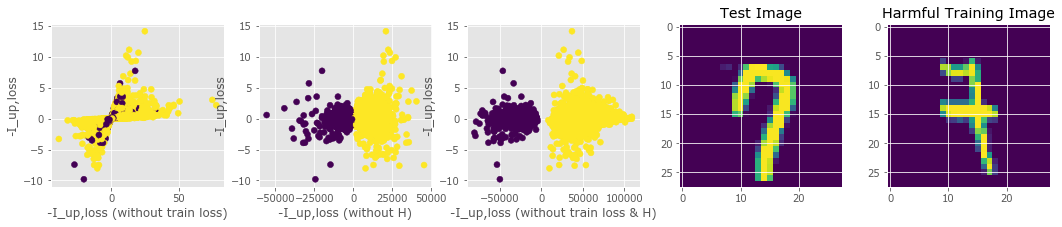

In [13]:
matplotlib.rcParams['figure.figsize'] = (18,3)
plt.subplot(1,5,1)
plt.scatter(-d[2],-d[0],c=d[4])
plt.xlabel('-I_up,loss (without train loss)')
plt.ylabel('-I_up,loss')
plt.subplot(1,5,2)
plt.scatter(-d[1],-d[0],c=d[4])
plt.xlabel('-I_up,loss (without H)')
plt.ylabel('-I_up,loss')
plt.subplot(1,5,3)
plt.scatter(-d[3],-d[0],c=d[4])
plt.xlabel('-I_up,loss (without train loss & H)')
plt.ylabel('-I_up,loss')
plt.subplot(1,5,4)
plt.imshow(X_test.reshape(28,28))
plt.title('Test Image')
plt.subplot(1,5,5)
plt.imshow(X[:,idx].reshape(28,28))
plt.title('Harmful Training Image')

plt.savefig('component influence.eps', format='eps', dpi=1000)

__Comments:__

This graph fits the pattern in Figure 1. Purple dots are training data with the same label as test data; yellow are the oppisite.

__Left:__ Without the train loss term, we overestimate the influence of many training points: the points near the y=0 line should have I_up,loss close to 0, but instead have high influence when we remove the train loss term.
__Mid:__ Without Hessian, all purple points are benefitial to the prediction (removing each point will increase the loss) while all yellow points are harmful (removing each point will decrease the loss). But this might not be true since some incorrect training data can have positive impact on the model as well. Also, this loss has a huge multiplier.
__Right:__ Without training loss or Hessian, what is left is the scaled Euclidean inner product. This is similar to the mid graph but spread more widely.